<a href="https://colab.research.google.com/github/John-Akech/Formative-2---Data-Preprocessing_Final-Notebook/blob/master/Formative_2_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Data Augmentation on CSV Files

# Data Cleaning & Handling Missing Values

In [12]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from imblearn.over_sampling import SMOTE
import uuid

In [13]:
# Load the Dataset
try:
    # Load the dataset
    df = pd.read_csv('/content/customer_transactions.csv')
except FileNotFoundError:
    print("Error: The file 'customer_transactions.csv' was not found.")
    exit()

In [14]:
# Display basic information
print("\nDataset Overview:")
print(df.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_legacy  150 non-null    int64  
 1   transaction_id      150 non-null    int64  
 2   purchase_amount     150 non-null    int64  
 3   purchase_date       150 non-null    object 
 4   product_category    150 non-null    object 
 5   customer_rating     140 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ KB
None


In [15]:
# Display first few rows
print("\nFirst 5 Rows:")
print(df.head())


First 5 Rows:
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3                 171            1004              256    2024-01-04   
4                 160            1005               64    2024-01-05   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothing              1.3  


In [16]:
# Ensure Correct Data Types
numerical_cols = ['purchase_amount', 'customer_rating']
categorical_cols = ['product_category']

In [17]:
# Convert purchase_date to datetime
df['purchase_date'] = pd.to_datetime(df['purchase_date'], errors='coerce')

In [18]:
# Extract year, month, and day from purchase_date
df['year'] = df['purchase_date'].dt.year
df['month'] = df['purchase_date'].dt.month
df['day'] = df['purchase_date'].dt.day

In [19]:
# Drop the original purchase_date column
df.drop(columns=['purchase_date'], inplace=True)

In [20]:
# Ensure numerical columns are numeric
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')# Ensure categorical columns are category type
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [21]:
# Verify updated data types
print("\nUpdated Data Types:")
print(df.dtypes)


Updated Data Types:
customer_id_legacy       int64
transaction_id           int64
purchase_amount          int64
product_category      category
customer_rating        float64
year                     int32
month                    int32
day                      int32
dtype: object


In [22]:
# Handle Missing Values
# Check for missing values
print("\nMissing Values Summary:")
print(df.isnull().sum())


Missing Values Summary:
customer_id_legacy     0
transaction_id         0
purchase_amount        0
product_category       0
customer_rating       10
year                   0
month                  0
day                    0
dtype: int64


In [23]:
# Impute numerical columns using median
imputer = SimpleImputer(strategy='median')
df[numerical_cols + ['year', 'month', 'day']] = imputer.fit_transform(df[numerical_cols + ['year', 'month', 'day']])

In [24]:
# Impute categorical columns using mode
for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)
    print(f"\nFilled missing values in {col} with mode: {mode_value}")


Filled missing values in product_category with mode: Sports


<ipython-input-24-b5588db212dd>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)


In [25]:
# Predictive modeling for remaining missing values in customer_rating
if df['customer_rating'].isnull().any():
    X_train = df[df['customer_rating'].notnull()][['purchase_amount']]
    y_train = df[df['customer_rating'].notnull()]['customer_rating']
    X_missing = df[df['customer_rating'].isnull()][['purchase_amount']]

    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    df.loc[df['customer_rating'].isnull(), 'customer_rating'] = regressor.predict(X_missing)

In [26]:
# Verify missing values are handled
print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
customer_id_legacy    0
transaction_id        0
purchase_amount       0
product_category      0
customer_rating       0
year                  0
month                 0
day                   0
dtype: int64


# Data Augmentation Strategies

In [27]:
# Apply Random Noise to Numerical Columns
# Add random noise to purchase_amount
noise_factor = 0.05  # Adjust noise factor for better augmentation
original_std = df['purchase_amount'].std()
df['purchase_amount'] += np.random.normal(0, noise_factor * original_std, df.shape[0])

print("\nRandom Noise Applied to purchase_amount:")
print(df[['purchase_amount']].head())


Random Noise Applied to purchase_amount:
   purchase_amount
0       410.736047
1       330.177365
2       427.791346
3       251.792688
4        60.237635


In [28]:
# Generate Synthetic Data (Choose One Approach)

# Approach 1: Discretize Target Variable and Use SMOTE
def augment_with_smote(df):
    # Encode categorical variables
    X = df.drop(columns=['customer_id_legacy', 'transaction_id', 'customer_rating'])
    y = df['customer_rating']

    # One-hot encode categorical features
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_encoded = encoder.fit_transform(X[categorical_cols])
    X_encoded = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))
    X_final = pd.concat([X.drop(columns=categorical_cols), X_encoded], axis=1)

    # Discretize the continuous target into bins
    discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
    y_discrete = discretizer.fit_transform(y.values.reshape(-1, 1)).ravel()

    # Apply SMOTE to the discretized target
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_final, y_discrete)

    # Decode the discretized target back to the original scale
    y_resampled_continuous = discretizer.inverse_transform(y_resampled.reshape(-1, 1)).ravel()

    # Combine resampled data into a DataFrame
    synthetic_data = pd.DataFrame(X_resampled, columns=X_final.columns)
    synthetic_data['customer_rating'] = y_resampled_continuous

    # Decode one-hot-encoded features back to original format
    def decode_one_hot(encoded_df, original_df):
        decoded_df = pd.DataFrame(index=encoded_df.index)
        for col in categorical_cols:
            one_hot_cols = [c for c in encoded_df.columns if c.startswith(col)]
            decoded_df[col] = encoded_df[one_hot_cols].idxmax(axis=1).str.replace(f"{col}_", "")
        return decoded_df

    decoded_categoricals = decode_one_hot(synthetic_data, X)
    synthetic_data = pd.concat([synthetic_data.drop(columns=[c for c in synthetic_data.columns if any(cat in c for cat in categorical_cols)]), decoded_categoricals], axis=1)

    # Generate synthetic IDs
    synthetic_data['customer_id_legacy'] = [uuid.uuid4().int % 10**9 for _ in range(synthetic_data.shape[0])]
    synthetic_data['transaction_id'] = range(df['transaction_id'].max() + 1, df['transaction_id'].max() + 1 + synthetic_data.shape[0])

    return synthetic_data

In [29]:
# Approach 2: Interpolation for Continuous Target
def augment_with_interpolation(df):
    # Function to generate synthetic samples via interpolation
    def interpolate_data(X, y, n_samples):
        synthetic_X = []
        synthetic_y = []

        for _ in range(n_samples):
            # Randomly select two samples
            idx1, idx2 = np.random.choice(len(X), size=2, replace=False)
            alpha = np.random.uniform(0, 1)  # Interpolation factor

            # Interpolate features and target
            synthetic_X.append(alpha * X.iloc[idx1] + (1 - alpha) * X.iloc[idx2])
            synthetic_y.append(alpha * y.iloc[idx1] + (1 - alpha) * y.iloc[idx2])

        synthetic_X = pd.DataFrame(synthetic_X, columns=X.columns)
        synthetic_y = pd.Series(synthetic_y, name=y.name)
        return synthetic_X, synthetic_y

    # Prepare data for augmentation
    X = df.drop(columns=['customer_id_legacy', 'transaction_id', 'customer_rating'])
    y = df['customer_rating']

    # Generate synthetic data
    n_synthetic_samples = len(df)  # Generate as many synthetic samples as the original dataset
    synthetic_X, synthetic_y = interpolate_data(X, y, n_synthetic_samples)

    # Combine synthetic data into a DataFrame
    synthetic_data = pd.concat([synthetic_X, synthetic_y], axis=1)
    synthetic_data.columns = X.columns.tolist() + ['customer_rating']

    # Generate synthetic IDs
    synthetic_data['customer_id_legacy'] = [uuid.uuid4().int % 10**9 for _ in range(synthetic_data.shape[0])]
    synthetic_data['transaction_id'] = range(df['transaction_id'].max() + 1, df['transaction_id'].max() + 1 + synthetic_data.shape[0])

    return synthetic_data

In [30]:
# Choose an augmentation approach
augmentation_method = "smote"  # Change to "interpolation" if needed

if augmentation_method == "smote":
    synthetic_data = augment_with_smote(df)
elif augmentation_method == "interpolation":
    synthetic_data = augment_with_interpolation(df)

# Concatenate synthetic data with the original dataset
df_augmented = pd.concat([df, synthetic_data], axis=0).reset_index(drop=True)

print("\nSynthetic Data Generated:")
print(synthetic_data.head())


Synthetic Data Generated:
   purchase_amount    year  month  day  customer_rating product_category  \
0       410.736047  2024.0    1.0  1.0         1.666667           Sports   
1       330.177365  2024.0    1.0  2.0         4.333333      Electronics   
2       427.791346  2024.0    1.0  3.0         1.666667      Electronics   
3       251.792688  2024.0    1.0  4.0         3.000000         Clothing   
4        60.237635  2024.0    1.0  5.0         1.666667         Clothing   

   customer_id_legacy  transaction_id  
0           945955825            1151  
1           734237475            1152  
2           419766466            1153  
3           293943581            1154  
4           642647820            1155  


In [31]:
# Transform Skewed Features
# Check skewness
skewness = df['purchase_amount'].skew()
print(f"\nSkewness of purchase_amount: {skewness}")

# Apply log transformation if skewed
if skewness > 1:
    df['purchase_amount'] = np.log1p(df['purchase_amount'])
    print("\nLog Transformation Applied to purchase_amount.")

print("\nTransformed purchase_amount:")
print(df[['purchase_amount']].head())


Skewness of purchase_amount: 0.07284565843753775

Transformed purchase_amount:
   purchase_amount
0       410.736047
1       330.177365
2       427.791346
3       251.792688
4        60.237635


# Export the Augmented Data

In [32]:
# Export the Augmented Dataset
output_file = 'customer_transactions_augmented.csv'
df_augmented.to_csv(output_file, index=False)

print(f"\nAugmented Dataset Saved Successfully as '{output_file}'!")


Augmented Dataset Saved Successfully as 'customer_transactions_augmented.csv'!


 # Part 2: Merging Datasets with Transitive Properties

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Load the Datasets
try:
    # Load the augmented transactions dataset
    transactions_df = pd.read_csv('/content/customer_transactions_augmented.csv')
except FileNotFoundError:
    print("Error: The file 'customer_transactions_augmented.csv' was not found.")
    exit()

In [3]:
try:
    # Load the social profiles dataset
    social_profiles_df = pd.read_csv('/content/customer_social_profiles.csv')
except FileNotFoundError:
    print("Error: The file 'customer_social_profiles.csv' was not found.")
    exit()

In [4]:
try:
    # Load the ID mapping dataset
    id_mapping_df = pd.read_csv('/content/id_mapping.csv')
except FileNotFoundError:
    print("Error: The file 'id_mapping.csv' was not found.")
    exit()

In [5]:
# Display basic information about all datasets
print("\nTransactions Dataset Overview:")
print(transactions_df.info())


Transactions Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_legacy  315 non-null    int64  
 1   transaction_id      315 non-null    int64  
 2   purchase_amount     315 non-null    float64
 3   product_category    315 non-null    object 
 4   customer_rating     315 non-null    float64
 5   year                315 non-null    float64
 6   month               315 non-null    float64
 7   day                 315 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 19.8+ KB
None


In [6]:
# Map IDs Using id_mapping.csv
# Merge transactions_df with id_mapping_df to get customer_id_new
transactions_mapped = pd.merge(
    transactions_df,
    id_mapping_df,
    left_on='customer_id_legacy',
    right_on='customer_id_legacy',
    how='left'
)
print("\nTransactions Mapped with New IDs:")
print(transactions_mapped.head())


Transactions Mapped with New IDs:
   customer_id_legacy  transaction_id  purchase_amount product_category  \
0                 151            1001       410.736047           Sports   
1                 192            1002       330.177365      Electronics   
2                 192            1002       330.177365      Electronics   
3                 192            1002       330.177365      Electronics   
4                 192            1002       330.177365      Electronics   

   customer_rating    year  month  day customer_id_new  
0              2.3  2024.0    1.0  1.0            A176  
1              4.2  2024.0    1.0  2.0            A156  
2              4.2  2024.0    1.0  2.0            A108  
3              4.2  2024.0    1.0  2.0            A110  
4              4.2  2024.0    1.0  2.0            A140  


In [7]:
# Debugging: Check if customer_id_new exists
if 'customer_id_new' not in transactions_mapped.columns:
    raise KeyError("Column 'customer_id_new' is missing after merging transactions_df with id_mapping_df.")

# Merge social_profiles_df with id_mapping_df to get customer_id_legacy
social_profiles_mapped = pd.merge(
    social_profiles_df,
    id_mapping_df,
    left_on='customer_id_new',
    right_on='customer_id_new',
    how='left'
)
print("\nSocial Profiles Mapped with Legacy IDs:")
print(social_profiles_mapped.head())


Social Profiles Mapped with Legacy IDs:
  customer_id_new social_media_platform  engagement_score  \
0            A178              LinkedIn                74   
1            A178              LinkedIn                74   
2            A190               Twitter                82   
3            A150              Facebook                96   
4            A162               Twitter                89   

   purchase_interest_score review_sentiment  customer_id_legacy  
0                      4.9         Positive               199.0  
1                      4.9         Positive               116.0  
2                      4.8          Neutral                 NaN  
3                      1.6         Positive               167.0  
4                      2.6         Positive               195.0  


In [8]:
# Debugging: Check if customer_id_legacy exists
if 'customer_id_legacy' not in social_profiles_mapped.columns:
    raise KeyError("Column 'customer_id_legacy' is missing after merging social_profiles_df with id_mapping_df.")

In [9]:
# Merge Both Datasets Based on Transitive Relationships
# Merge the two mapped datasets on customer_id_new
merged_df = pd.merge(
    transactions_mapped,
    social_profiles_mapped,
    on='customer_id_new',
    how='outer'
)
print("\nFinal Merged Dataset:")
print(merged_df.head())


Final Merged Dataset:
   customer_id_legacy_x  transaction_id  purchase_amount product_category  \
0                   NaN             NaN              NaN              NaN   
1                   NaN             NaN              NaN              NaN   
2                 163.0          1022.0       229.785186        Groceries   
3                 163.0          1022.0       229.785186        Groceries   
4                 163.0          1044.0       488.135942           Sports   

   customer_rating    year  month   day customer_id_new social_media_platform  \
0              NaN     NaN    NaN   NaN            A100               Twitter   
1              NaN     NaN    NaN   NaN            A100             Instagram   
2              2.7  2024.0    1.0  22.0            A101               Twitter   
3              2.7  2024.0    1.0  22.0            A101               Twitter   
4              3.0  2024.0    2.0  13.0            A101               Twitter   

   engagement_score  purcha

In [10]:
# Debugging: Check for missing columns
missing_columns = ['customer_id_new', 'customer_id_legacy', 'engagement_score']
for col in missing_columns:
    if col not in merged_df.columns:
        print(f"Warning: Column '{col}' is missing in the final merged dataset.")

In [11]:
# Handle conflicts where one customer ID maps to multiple entries
# Aggregate duplicate rows by taking the mean of numerical columns and mode of categorical columns
def aggregate_duplicates(df):
    # Group by customer_id_new and aggregate
    aggregation_dict = {
        'purchase_amount': 'mean',
        'customer_rating': 'mean',
        'engagement_score': lambda x: x.sum() if 'engagement_score' in df.columns else np.nan,
        'purchase_interest_score': 'mean'
    }

    # Only include customer_id_legacy if it exists
    if 'customer_id_legacy' in df.columns:
        aggregation_dict['customer_id_legacy'] = lambda x: x.mode()[0] if not x.empty else np.nan

    aggregated_df = df.groupby('customer_id_new', as_index=False).agg(aggregation_dict)
    return aggregated_df

merged_df = aggregate_duplicates(merged_df)
print("\nAggregated Merged Dataset:")
print(merged_df.head())


Aggregated Merged Dataset:
  customer_id_new  purchase_amount  customer_rating  engagement_score  \
0            A100              NaN              NaN             154.0   
1            A101       358.960564             2.85             272.0   
2            A102       298.071080             3.20             816.0   
3            A103       175.576949             3.20             386.0   
4            A104              NaN              NaN             249.0   

   purchase_interest_score  
0                 4.400000  
1                 1.000000  
2                 4.800000  
3                 2.866667  
4                 2.933333  


In [12]:
# Create a Customer Engagement Score
# Combine transaction history (purchase_amount) and engagement_score
if 'engagement_score' in merged_df.columns:
    merged_df['customer_engagement_score'] = (
        merged_df['purchase_amount'] * 0.6 +
        merged_df['engagement_score'] * 0.4
    )
else:
    print("Warning: 'engagement_score' column is missing. Skipping customer engagement score calculation.")
    merged_df['customer_engagement_score'] = merged_df['purchase_amount'] * 0.6

print("\nCustomer Engagement Score Added:")
print(merged_df[['customer_id_new', 'customer_engagement_score']].head())


Customer Engagement Score Added:
  customer_id_new  customer_engagement_score
0            A100                        NaN
1            A101                 324.176338
2            A102                 505.242648
3            A103                 259.746170
4            A104                        NaN


In [13]:
# Engineer predictive behavioral features
# Moving average of transactions (rolling window of 3)
merged_df.sort_values(by=['customer_id_new'], inplace=True)
merged_df['moving_avg_purchase'] = merged_df.groupby('customer_id_new')['purchase_amount'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
print("\nMoving Average of Purchases Added:")
print(merged_df[['customer_id_new', 'purchase_amount', 'moving_avg_purchase']].head())


Moving Average of Purchases Added:
  customer_id_new  purchase_amount  moving_avg_purchase
0            A100              NaN                  NaN
1            A101       358.960564           358.960564
2            A102       298.071080           298.071080
3            A103       175.576949           175.576949
4            A104              NaN                  NaN


In [14]:
# Time-based aggregation of purchases (e.g., monthly total)
# Convert purchase_date to datetime
if 'purchase_date' in merged_df.columns:
    merged_df['month'] = merged_df['purchase_date'].dt.to_period('M').astype(str)
    monthly_aggregation = merged_df.groupby(['customer_id_new', 'month'])['purchase_amount'].sum().reset_index()
    monthly_aggregation.rename(columns={'purchase_amount': 'monthly_total_purchase'}, inplace=True)
    merged_df = pd.merge(merged_df, monthly_aggregation, on=['customer_id_new', 'month'], how='left')
    print("\nMonthly Aggregation of Purchases Added:")
    print(merged_df[['customer_id_new', 'month', 'monthly_total_purchase']].head())
else:
    print("Warning: 'purchase_date' column is missing. Skipping time-based aggregation.")

# TF-IDF on review_sentiment
if 'review_sentiment' in merged_df.columns:
    tfidf = TfidfVectorizer(max_features=10)  # Limit to top 10 features for simplicity
    tfidf_matrix = tfidf.fit_transform(merged_df['review_sentiment'].fillna(''))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    merged_df = pd.concat([merged_df.reset_index(drop=True), tfidf_df], axis=1)
    print("\nTF-IDF Features Added:")
    print(merged_df.head())
else:
    print("Warning: 'review_sentiment' column is missing. Skipping TF-IDF feature extraction.")

In [15]:
# Export the Final Preprocessed Data
# Save the final dataset
output_file = 'final_customer_data_group17.csv'
merged_df.to_csv(output_file, index=False)

print(f"\nFinal Preprocessed Dataset Saved Successfully as '{output_file}'!")


Final Preprocessed Dataset Saved Successfully as 'final_customer_data_group17.csv'!


# Part 3: Data Consistency and Quality Checks

Objective: Ensure that the preprocessed dataset is clean, structured, and machine learning-ready.

In [16]:
# Check for Duplicate Entries
print("\nChecking for Duplicate Entries:")
if merged_df.duplicated().any():
    print("Duplicate entries found. Dropping duplicates...")
    merged_df.drop_duplicates(inplace=True)
else:
    print("No duplicate entries found.")


Checking for Duplicate Entries:
No duplicate entries found.


In [17]:
# Ensure All Categorical Values Are Correctly Mapped
print("\nValidating Categorical Values:")
categorical_cols = ['product_category', 'review_sentiment']  # Add relevant categorical columns here
for col in categorical_cols:
    if col in merged_df.columns:
        unique_values = merged_df[col].unique()
        print(f"Unique values in {col}: {unique_values}")
    else:
        print(f"Warning: Column '{col}' is missing. Skipping validation.")


Validating Categorical Values:


In [18]:
# Validate That All Customer Transactions Match a Valid Social Profile
print("\nValidating Customer Transactions Against Social Profiles:")
if 'customer_id_new' in merged_df.columns:
    unmatched_transactions = merged_df['customer_id_new'].isnull().sum()
    if unmatched_transactions > 0:
        print(f"Warning: {unmatched_transactions} transactions do not match a valid social profile.")
    else:
        print("All customer transactions match a valid social profile.")
else:
    print("Warning: 'customer_id_new' column is missing. Skipping validation.")


Validating Customer Transactions Against Social Profiles:
All customer transactions match a valid social profile.


In [19]:
# Generate describe() Reports for Numerical Columns
print("\nStatistical Summary for Numerical Columns:")
numerical_cols = ['purchase_amount', 'customer_rating', 'engagement_score', 'purchase_interest_score']
if any(col in merged_df.columns for col in numerical_cols):
    print(merged_df[numerical_cols].describe())
else:
    print("Warning: No numerical columns found for summarization.")


Statistical Summary for Numerical Columns:
       purchase_amount  customer_rating  engagement_score  \
count        65.000000        65.000000         95.000000   
mean        288.259405         3.113324        637.242105   
std          78.337977         0.923057       1123.160536   
min         101.620325         1.100000          0.000000   
25%         219.150660         2.550000         80.000000   
50%         295.328005         3.000000        227.000000   
75%         345.496229         3.620000        750.000000   
max         435.950935         4.900000       8589.000000   

       purchase_interest_score  
count                84.000000  
mean                  3.145065  
std                   0.973007  
min                   1.000000  
25%                   2.650000  
50%                   3.250000  
75%                   3.862500  
max                   4.900000  



Visualizing Distribution of Transaction Amounts:


Text(0, 0.5, 'Frequency')

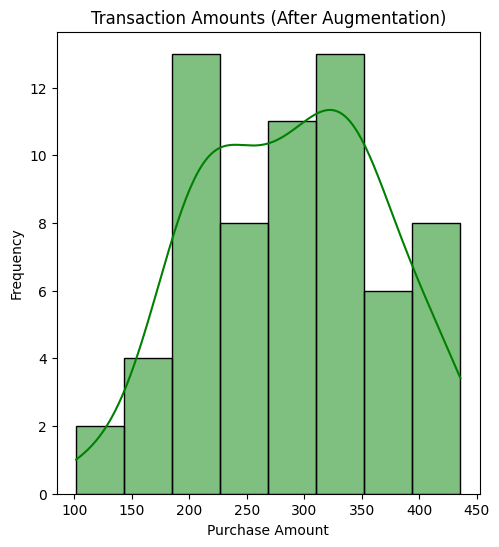

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\nVisualizing Distribution of Transaction Amounts:")
plt.figure(figsize=(12, 6))

# Before augmentation (original dataset)
if 'df' in locals():  # Check if the original dataset exists
    plt.subplot(1, 2, 1)
    sns.histplot(df['purchase_amount'], kde=True, color='blue')
    plt.title('Transaction Amounts (Before Augmentation)')
    plt.xlabel('Purchase Amount')
    plt.ylabel('Frequency')

# After augmentation (final dataset)
plt.subplot(1, 2, 2)
sns.histplot(merged_df['purchase_amount'], kde=True, color='green')
plt.title('Transaction Amounts (After Augmentation)')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')


Identifying Highly Correlated Features:


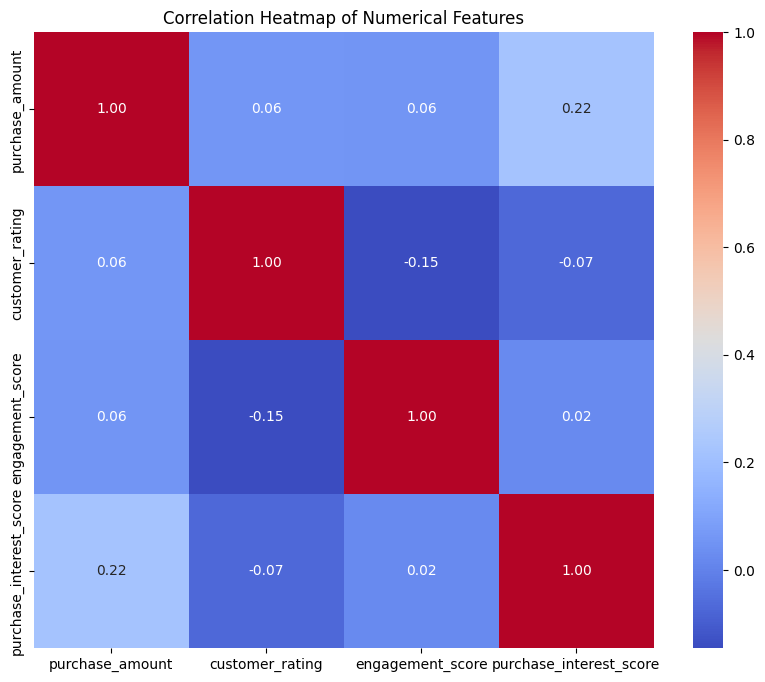


Selecting Top 10 Most Important Features:
Top 10 Selected Features:
Index(['purchase_amount', 'customer_rating', 'engagement_score',
       'purchase_interest_score', 'customer_engagement_score',
       'moving_avg_purchase'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=10 is greater than n_features=6. All the features will be returned.
  warnings.warn(


In [22]:
# Identify Highly Correlated Features Using a Correlation Heatmap
print("\nIdentifying Highly Correlated Features:")
numerical_cols = ['purchase_amount', 'customer_rating', 'engagement_score', 'purchase_interest_score']
correlation_matrix = merged_df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Select the Top 10 Most Important Features Using a Feature Selection Algorithm
from sklearn.feature_selection import SelectKBest, f_regression

print("\nSelecting Top 10 Most Important Features:")
X = merged_df.drop(columns=['customer_id_new', 'customer_id_legacy', 'transaction_id'], errors='ignore')
y = merged_df['customer_engagement_score'] if 'customer_engagement_score' in merged_df.columns else None

# Check for missing values in y
if y is not None and y.isnull().any():
    print("Warning: Missing values found in the target variable 'customer_engagement_score'. Dropping rows with missing values...")
    # Drop rows with missing values in y
    valid_indices = y.notnull()
    X = X[valid_indices]
    y = y[valid_indices]

# Check for missing values in X
if X.isnull().values.any():
    print("Warning: Missing values found in X. Imputing missing values...")
    from sklearn.impute import SimpleImputer

    # Impute missing values in numerical columns using median
    numerical_imputer = SimpleImputer(strategy='median')
    X_numerical = X.select_dtypes(include=['float64', 'int64'])
    X[X_numerical.columns] = numerical_imputer.fit_transform(X_numerical)

    # Impute missing values in categorical columns using mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_categorical = X.select_dtypes(include=['object', 'category'])
    if not X_categorical.empty:
        X[X_categorical.columns] = categorical_imputer.fit_transform(X_categorical)

# Ensure all columns are numeric for SelectKBest
X = pd.get_dummies(X, drop_first=True)

if y is not None:
    selector = SelectKBest(score_func=f_regression, k=10)
    X_selected = selector.fit_transform(X, y)

    selected_features = X.columns[selector.get_support()]
    print("Top 10 Selected Features:")
    print(selected_features)
else:
    print("Warning: Target variable 'customer_engagement_score' is missing. Skipping feature selection.")

In [23]:
# Save the Final Dataset
output_file = 'final_dataset_ready_group17.csv'
merged_df.to_csv(output_file, index=False)

print(f"\nFinal Dataset Saved Successfully as '{output_file}'!")


Final Dataset Saved Successfully as 'final_dataset_ready_group17.csv'!


# Bonus Challenge (Machine Learning Model to Predict Customer Spending)

In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [25]:
# Load the Final Preprocessed Dataset
try:
    # Load the dataset
    df = pd.read_csv('/content/final_customer_data_group17.csv')
except FileNotFoundError:
    print("Error: The file 'final_customer_data_group17.csv' was not found.")
    exit()

In [26]:
# Display basic information about the dataset
print("\nDataset Overview:")
print(df.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id_new            95 non-null     object 
 1   purchase_amount            65 non-null     float64
 2   customer_rating            65 non-null     float64
 3   engagement_score           95 non-null     float64
 4   purchase_interest_score    84 non-null     float64
 5   customer_engagement_score  65 non-null     float64
 6   moving_avg_purchase        65 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.3+ KB
None


In [27]:
# Prepare Features and Target Variable
# Define the target variable (e.g., purchase_amount)
target_column = 'purchase_amount'

# Drop non-numeric and irrelevant columns
drop_columns = ['customer_id_new', 'customer_id_legacy', 'transaction_id', 'review_sentiment']
if 'review_sentiment' in df.columns:
    drop_columns.append('review_sentiment')

X = df.drop(columns=[target_column] + drop_columns, errors='ignore')
y = df[target_column]

# Ensure all features are numeric
X = pd.get_dummies(X, drop_first=True)

In [28]:
# Handle Missing Values in y
if y.isnull().any():
    print("Warning: Missing values found in the target variable. Dropping rows with missing values...")
    valid_indices = y.notnull()
    X = X[valid_indices]
    y = y[valid_indices]

In [29]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining and Testing Data Shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Training and Testing Data Shapes:
X_train: (52, 5), X_test: (13, 5)
y_train: (52,), y_test: (13,)


In [30]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train Models

# Check for missing values in X_train
if X_train.isnull().values.any():
    print("Warning: Missing values found in X_train. Imputing missing values...")

    # Impute missing values in numerical columns using median
    numerical_imputer = SimpleImputer(strategy='median')
    X_train_numerical = X_train.select_dtypes(include=['float64', 'int64'])
    X_train[X_train_numerical.columns] = numerical_imputer.fit_transform(X_train_numerical)

    # Impute missing values in categorical columns using mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_train_categorical = X_train.select_dtypes(include=['object', 'category'])
    if not X_train_categorical.empty:
        X_train[X_train_categorical.columns] = categorical_imputer.fit_transform(X_train_categorical)

# Ensure all features are numeric for Linear Regression
X_train = pd.get_dummies(X_train, drop_first=True)

# Similarly, preprocess X_test
if X_test.isnull().values.any():
    print("Warning: Missing values found in X_test. Imputing missing values...")

    # Impute missing values in numerical columns using median
    X_test_numerical = X_test.select_dtypes(include=['float64', 'int64'])
    X_test[X_test_numerical.columns] = numerical_imputer.transform(X_test_numerical)

    # Impute missing values in categorical columns using mode
    X_test_categorical = X_test.select_dtypes(include=['object', 'category'])
    if not X_test_categorical.empty:
        X_test[X_test_categorical.columns] = categorical_imputer.transform(X_test_categorical)

# Ensure all features are numeric for Linear Regression
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns between X_train and X_test (in case one-hot encoding creates different columns)
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Add missing columns with default value 0
X_test = X_test[X_train.columns]  # Reorder columns to match X_train

# Initialize models
linear_reg = LinearRegression()
random_forest = RandomForestRegressor(random_state=42, n_jobs=-1)
xgboost = XGBRegressor(random_state=42, n_jobs=-1)

# Train models separately
print("\nTraining Linear Regression Model...")
linear_reg.fit(X_train, y_train)

print("\nTraining Random Forest Model...")
random_forest.fit(X_train, y_train)

print("\nTraining XGBoost Model...")
xgboost.fit(X_train, y_train)

# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Evaluate each model
linear_reg_metrics = evaluate_model(linear_reg, X_test, y_test)
random_forest_metrics = evaluate_model(random_forest, X_test, y_test)
xgboost_metrics = evaluate_model(xgboost, X_test, y_test)

# Display evaluation results
print("\nModel Evaluation Results:")
print(f"Linear Regression - MAE: {linear_reg_metrics[0]:.2f}, MSE: {linear_reg_metrics[1]:.2f}, R²: {linear_reg_metrics[2]:.2f}")
print(f"Random Forest - MAE: {random_forest_metrics[0]:.2f}, MSE: {random_forest_metrics[1]:.2f}, R²: {random_forest_metrics[2]:.2f}")
print(f"XGBoost - MAE: {xgboost_metrics[0]:.2f}, MSE: {xgboost_metrics[1]:.2f}, R²: {xgboost_metrics[2]:.2f}")

# Compare Models and Identify the Best Model
models = {
    "Linear Regression": linear_reg_metrics,
    "Random Forest": random_forest_metrics,
    "XGBoost": xgboost_metrics
}

best_model_name = max(models, key=lambda k: models[k][2])  # Choose based on highest R² score
best_model = {"name": best_model_name, "metrics": models[best_model_name]}
print(f"\nBest Model: {best_model['name']} with R² Score: {best_model['metrics'][2]:.2f}")


Training Linear Regression Model...

Training Random Forest Model...

Training XGBoost Model...

Model Evaluation Results:
Linear Regression - MAE: 0.00, MSE: 0.00, R²: 1.00
Random Forest - MAE: 2.23, MSE: 7.57, R²: 1.00
XGBoost - MAE: 3.53, MSE: 23.22, R²: 0.99

Best Model: Linear Regression with R² Score: 1.00


In [31]:
# Evaluate Models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Evaluate each model
linear_reg_metrics = evaluate_model(linear_reg, X_test, y_test)
random_forest_metrics = evaluate_model(random_forest, X_test, y_test)
xgboost_metrics = evaluate_model(xgboost, X_test, y_test)

# Display evaluation results
print("\nModel Evaluation Results:")
print(f"Linear Regression - MAE: {linear_reg_metrics[0]:.2f}, MSE: {linear_reg_metrics[1]:.2f}, R²: {linear_reg_metrics[2]:.2f}")
print(f"Random Forest - MAE: {random_forest_metrics[0]:.2f}, MSE: {random_forest_metrics[1]:.2f}, R²: {random_forest_metrics[2]:.2f}")
print(f"XGBoost - MAE: {xgboost_metrics[0]:.2f}, MSE: {xgboost_metrics[1]:.2f}, R²: {xgboost_metrics[2]:.2f}")


Model Evaluation Results:
Linear Regression - MAE: 0.00, MSE: 0.00, R²: 1.00
Random Forest - MAE: 2.23, MSE: 7.57, R²: 1.00
XGBoost - MAE: 3.53, MSE: 23.22, R²: 0.99


In [32]:
# Compare Models and Identify the Best Model
models = {
    "Linear Regression": linear_reg_metrics,
    "Random Forest": random_forest_metrics,
    "XGBoost": xgboost_metrics
}

# Find the best model based on R² score
best_model_name = max(models, key=lambda k: models[k][2])
best_model = {"name": best_model_name, "metrics": models[best_model_name]}
print(f"\nBest Model: {best_model['name']} with R² Score: {best_model['metrics'][2]:.2f}")


Best Model: Linear Regression with R² Score: 1.00


In [33]:
# Save Models
# Save all models
joblib.dump(linear_reg, '/content/linear_regression_model.pkl')
joblib.dump(random_forest, '/content/random_forest_model.pkl')
joblib.dump(xgboost, '/content/xgboost_model.pkl')

# Save the best model separately
joblib.dump(
    linear_reg if best_model_name == "Linear Regression" else
    random_forest if best_model_name == "Random Forest" else
    xgboost,
    '/content/best_model.pkl'
)

print("\nAll models saved successfully!")
print("Best model saved as 'best_model.pkl'.")


All models saved successfully!
Best model saved as 'best_model.pkl'.


In [34]:
import os
import shutil
from google.colab import files  # For downloading files in Google Colab

# Create Folders for Data and Models
data_folder = 'data_files'
models_folder = 'model_files'

# Create the folders if they don't exist
os.makedirs(data_folder, exist_ok=True)
os.makedirs(models_folder, exist_ok=True)

# List of Files to Organize
data_files = [
    'customer_transactions_augmented.csv',
    'final_customer_data_group17.csv',
    'final_dataset_ready_group17.csv'
]

model_files = [
    'linear_regression_model.pkl',
    'random_forest_model.pkl',
    'xgboost_model.pkl'
]

# Move Data Files to the Data Folder
for file in data_files:
    if os.path.exists(file):  # Check if the file exists
        shutil.move(file, os.path.join(data_folder, file))
        print(f"Moved {file} to '{data_folder}' folder.")
    else:
        print(f"Warning: {file} not found.")

# Move Model Files to the Models Folder
for file in model_files:
    if os.path.exists(file):  # Check if the file exists
        shutil.move(file, os.path.join(models_folder, file))
        print(f"Moved {file} to '{models_folder}' folder.")
    else:
        print(f"Warning: {file} not found.")

# Zip the Folders for Download
shutil.make_archive(data_folder, 'zip', data_folder)  # Zip the data folder
shutil.make_archive(models_folder, 'zip', models_folder)  # Zip the models folder

print(f"\nZipped folders created: '{data_folder}.zip' and '{models_folder}.zip'.")

# Download the Zipped Folders
files.download(f'{data_folder}.zip')  # Download the data folder zip
files.download(f'{models_folder}.zip')  # Download the models folder zip

print("\nDownload links generated. Please check your downloads.")

Moved customer_transactions_augmented.csv to 'data_files' folder.
Moved final_customer_data_group17.csv to 'data_files' folder.
Moved final_dataset_ready_group17.csv to 'data_files' folder.
Moved linear_regression_model.pkl to 'model_files' folder.
Moved random_forest_model.pkl to 'model_files' folder.
Moved xgboost_model.pkl to 'model_files' folder.

Zipped folders created: 'data_files.zip' and 'model_files.zip'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download links generated. Please check your downloads.
